# 📊 Project: Automated Loan Eligibility Prediction
## 🔍 Phase 1: Exploratory Data Analysis (EDA) & Strategic Insights

---

### 🌍 **The Context**
In the rapidly evolving landscape of **Housing Finance**, data is the primary driver of strategic decision-making. Lenders struggle to minimize **Non-Performing Assets (NPAs)** while ensuring fair access to credit. 

Traditional manual underwriting is slow, biased, and inefficient. As financial institutions scale, the ability to **instantly and accurately** assess a borrower’s solvency—distinguishing between *eligibility* (approval) and *affordability* (loan size)—is essential for maintaining a healthy credit portfolio.

### ❓ **The Challenge**
The absence of automated predictive insights leads to:
* **💸 Revenue Loss:** Defaults directly impact profitability.
* **⚙ Operational Inefficiency:** Underwriters waste time on obvious rejections.
* **🚪 Missed Opportunities:** Valid applicants are rejected because of rigid, manual rules.

### 🎯 **Objectives of Phase 1 (EDA)**
Before building machine learning models, we must understand the "Typical Persona" and the key drivers of risk. In this notebook, we will:
1.  **Audit the Data:** Check for quality, missing values, and inconsistencies.
2.  **Uncover Patterns:** Use Univariate and Bivariate analysis to find what drives approvals.
3.  **Test Hypotheses:** Does higher income guarantee approval? Does having a co-applicant help?
4.  **Feature Engineering:** Create new metrics (like `Total_Income`) to resolve data paradoxes.

---

In [1]:
# --- Data Manipulation ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# Set a clean visual style
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

# Custom Color Palette for "Bank/Finance" feel
colors = ["#2a9d8f", "#e9c46a", "#e76f51"]
sns.set_palette(sns.color_palette(colors))

In [2]:
# Load the dataset
df = pd.read_csv(r"..\data\Loan.csv")

# Renaming columns for Pythonic standards (snake_case)
columns_name = {
    'ApplicantIncome' : "Applicant_Income",
    'CoapplicantIncome' : "Coapplicant_Income",
    'LoanAmount' : "Loan_Amount",
}

df.rename(columns=columns_name, inplace=True)

# Preview
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## 1. 🧹 Data Cleaning & Type Optimization
The dataset contains a mix of numerical and object types. To save memory and enable categorical plotting, we cast object columns to the `category` data type.

In [3]:
# Define columns groups
numeric_cols = ['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Loan_Amount_Term']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 
                    'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']

# Optimized Casting Function
def optimize_dtypes(df, cat_cols):
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
    return df

df = optimize_dtypes(df, categorical_cols)

# Check for duplicates and missing values
print(f"Duplicates Found: {df.duplicated().sum()}")
print("-" * 30)
df.info()

Duplicates Found: 0
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Loan_ID             614 non-null    object  
 1   Gender              601 non-null    category
 2   Married             611 non-null    category
 3   Dependents          599 non-null    category
 4   Education           614 non-null    category
 5   Self_Employed       582 non-null    category
 6   Applicant_Income    614 non-null    int64   
 7   Coapplicant_Income  614 non-null    float64 
 8   Loan_Amount         592 non-null    float64 
 9   Loan_Amount_Term    600 non-null    float64 
 10  Credit_History      564 non-null    category
 11  Property_Area       614 non-null    category
 12  Loan_Status         614 non-null    category
dtypes: category(8), float64(3), int64(1), object(1)
memory usage: 30.0+ KB


# 📈 EDA Section 1: Univariate Analysis
**Goal:** Understand the distribution of individual variables to identify outliers and the "Typical Applicant Profile."

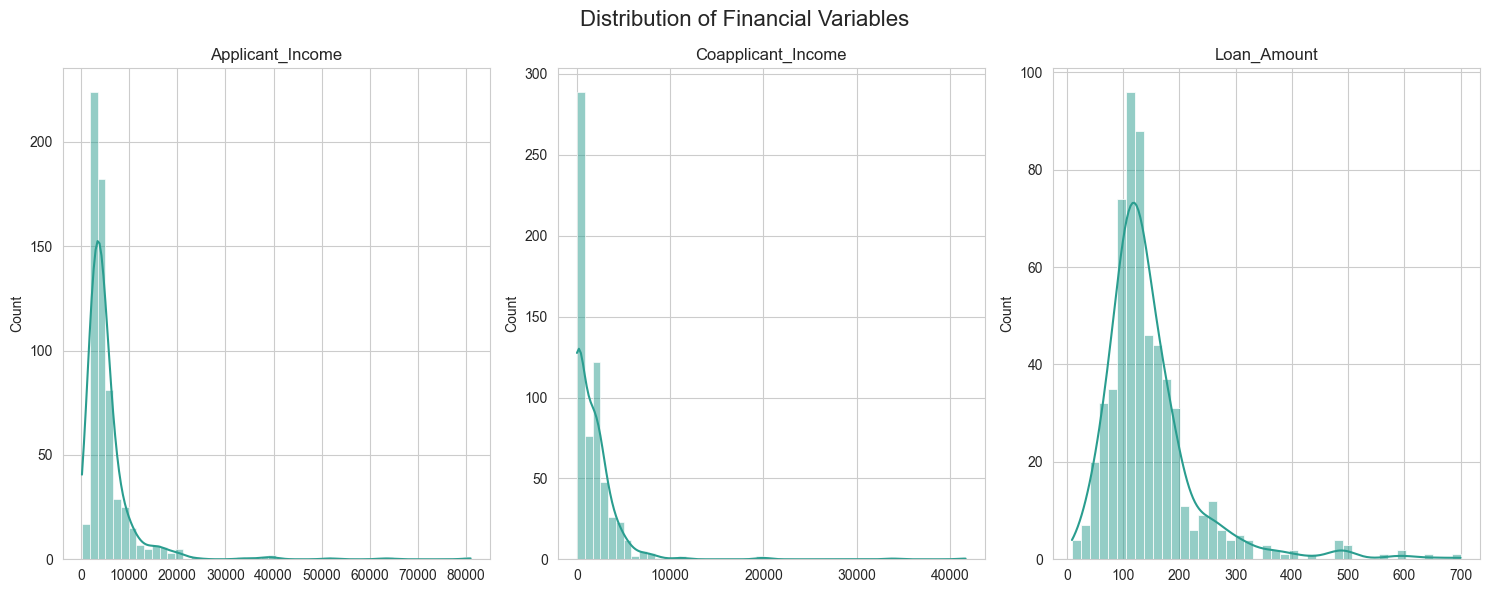

In [4]:
# Plotting Histograms for Numeric Variables
plt.figure(figsize=(15, 6))
plt.suptitle('Distribution of Financial Variables', fontsize=16)

for i, col in enumerate(['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col].dropna(), kde=True, color=colors[0])
    plt.title(col)
    plt.xlabel('')

plt.tight_layout()
plt.savefig(r'../plots/financial_variables_distribution.png')
plt.show()


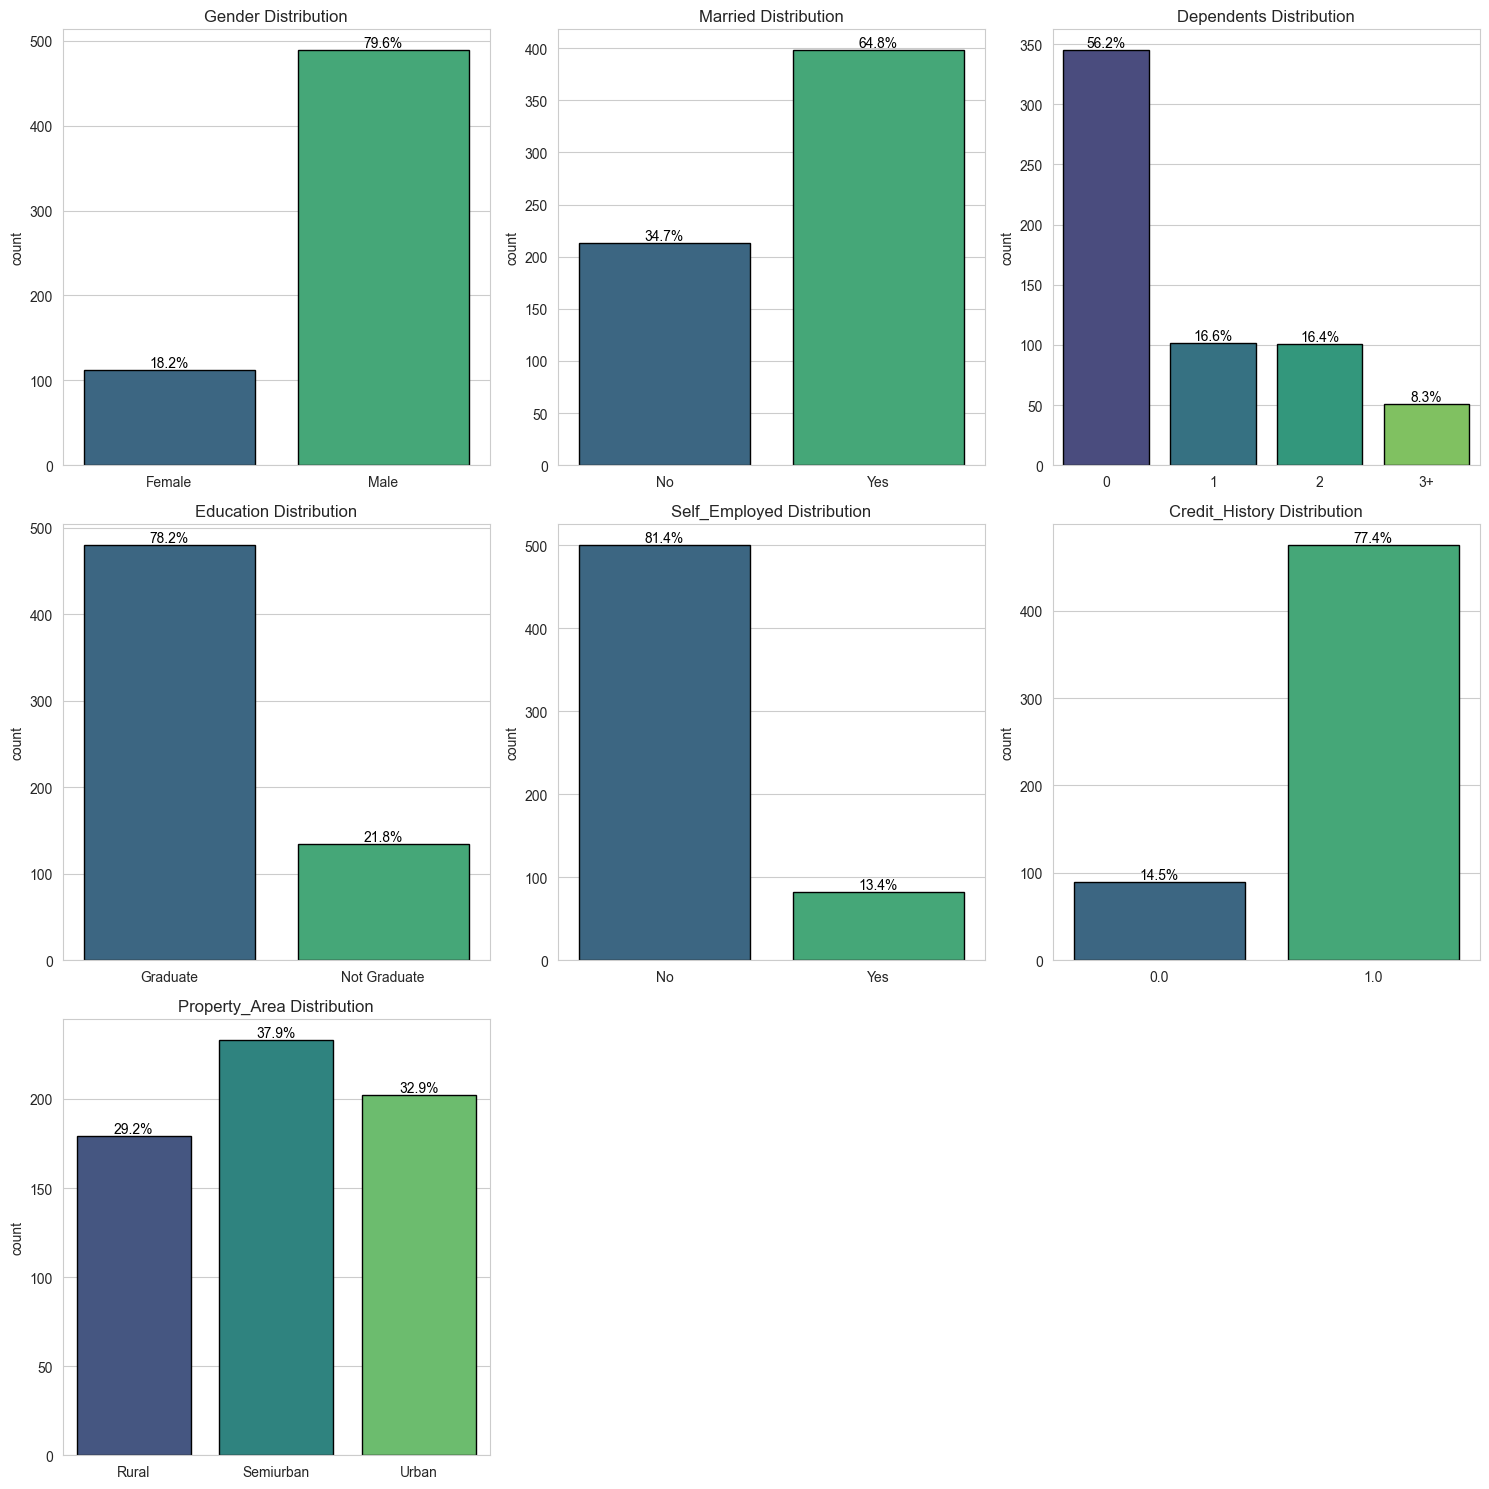

In [5]:
# 1. Select categorical features to plot (exclude ID and Target if needed)
# Note: Ensure 'Loan_Status' is in categorical_cols before running this
cols_to_plot = [col for col in categorical_cols if col != 'Loan_Status']

# 2. Dynamic Layout Calculation
n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

# 3. Create Subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# 4. Loop & Plot
for i, col in enumerate(cols_to_plot):
    if i < len(axes):
        # Countplot with the Fix: Added hue=col and legend=False
        ax = sns.countplot(data=df, x=col, hue=col, legend=False, ax=axes[i], palette='viridis', edgecolor='black')
        
        # Add Percentage Labels
        total = len(df)
        for p in ax.patches:
            height = p.get_height()
            percentage = f'{100 * height / total:.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, color='black')
        
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel('')

# 5. Clean up empty subplots
for j in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(r'../plots/categorical_distribution.png')
plt.show()

## 💡 Key Insights: The "Typical" Applicant
Our historical data indicates that the standard loan applicant is a **financially stable, salaried professional**.

* **Demographics:** Predominantly Male (81%), Married (65%), and Graduates (78%).
* **Employment:** 86% are **not self-employed**, indicating a focus on salaried individuals.
* **Credit Health:** **84%** of applicants have a Credit History of `1.0`, meeting the bank's guidelines.
* **Financial Skew:** Income is highly right-skewed. While the median is ~$3,800, high-net-worth outliers exist (earning >$80k).

# 🔗 EDA Section 2: Bivariate Analysis
**Goal:** Identify the drivers of `Loan_Status`. What separates an Approved loan from a Rejected one?

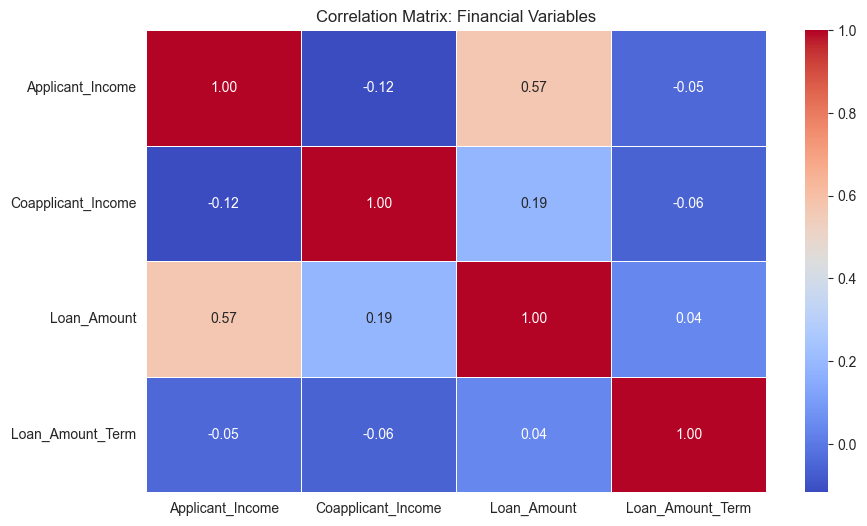

In [6]:
# Correlation Matrix (Numeric Only)
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include='number').corr(),
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Financial Variables")
plt.savefig(r'../plots/correlation_matrix.png')
plt.show()

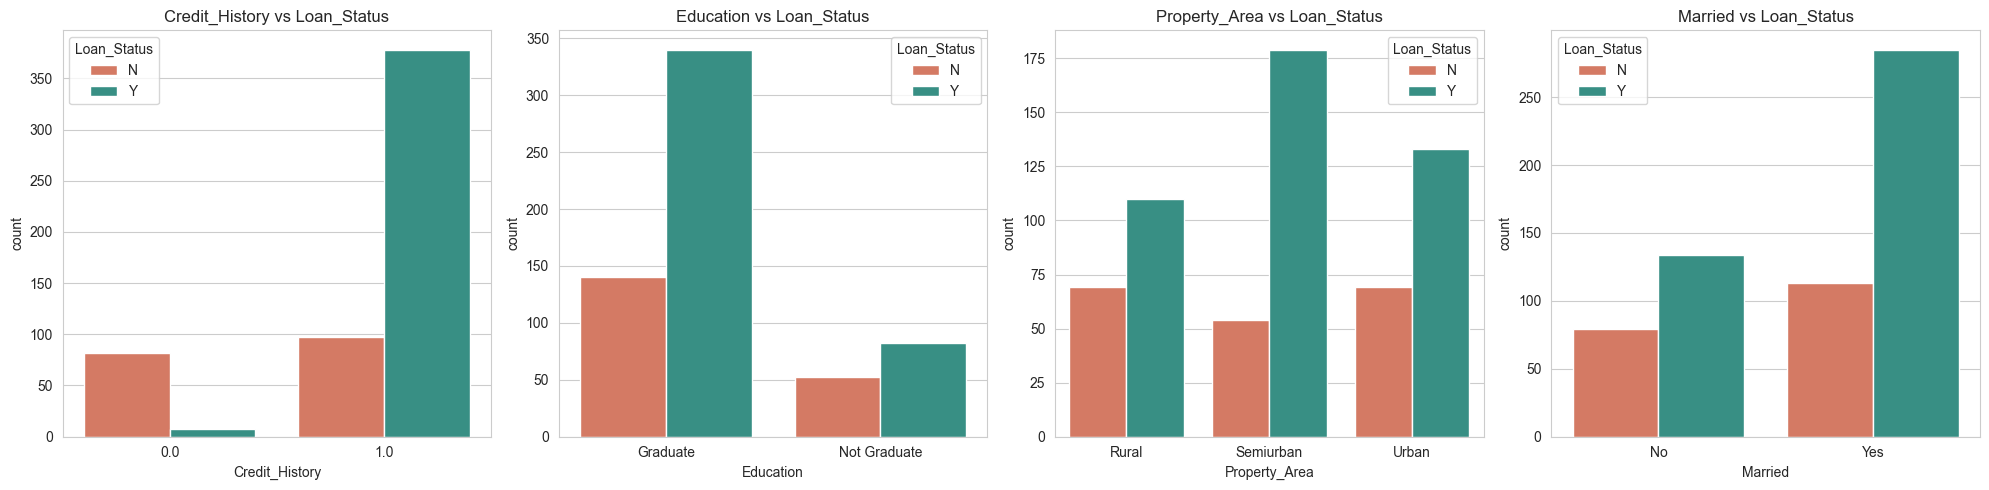

In [7]:
# Visualize Approval Rates by Category
cols_to_plot = ['Credit_History', 'Education', 'Property_Area', 'Married']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, col in enumerate(cols_to_plot):
    sns.countplot(x=col, hue='Loan_Status', data=df, ax=axes[i], palette={'Y': '#2a9d8f', 'N': '#e76f51'})
    axes[i].set_title(f'{col} vs Loan_Status')

plt.tight_layout()
plt.savefig(r'../plots/approval_rates.png')
plt.show()

## 🧾 Key Drivers of Loan Approval

### 1. 🟢 The "Gatekeeper": Credit History
* **Credit History is the single most important variable.**
* Applicants with a History of `1.0` have an **~80% approval rate**.
* Applicants with a History of `0.0` have a **near-zero** approval rate.

### 2. 🟢 The "Golden" Profile
Applicants who are **Married**, **Graduates**, and residing in **Semiurban** areas show consistently higher approval rates (>70%) compared to other demographics.

### 3. ❗ The Co-Applicant Paradox
* Higher **Co-Applicant Income** is paradoxically correlated with **higher rejection rates**.
* **Hypothesis:** Co-applicants are likely added when the primary applicant's financial position is weak. The combined income might still not be enough, or the risk remains too high. 
* **Action:** We need to engineer a `Total_Income` feature to see the true picture.

# 🛠️ Feature Engineering
To resolve the Co-applicant Paradox and better estimate affordability, we combine the income streams.

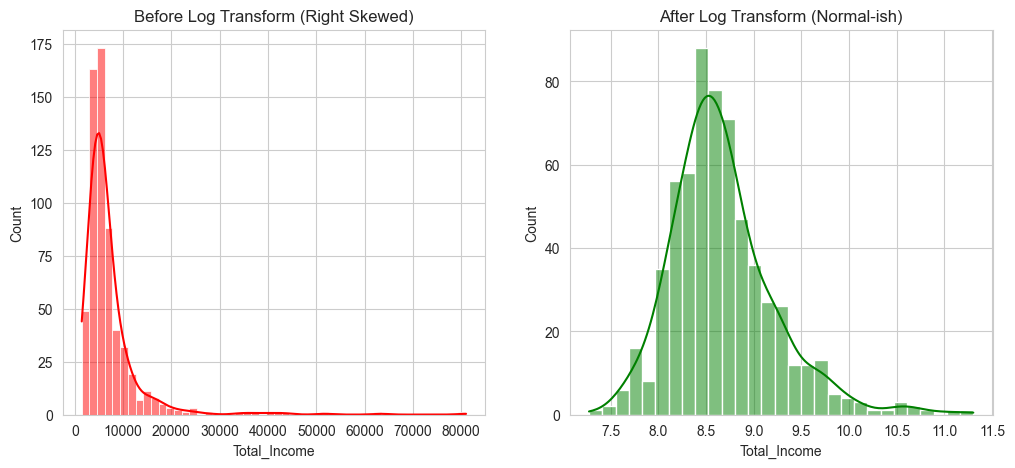

In [8]:
# Create Total_Income
df['Total_Income'] = df['Applicant_Income'] + df['Coapplicant_Income']

# Log Transformation (visualizing the effect)
# We will apply this permanently in the Pipeline phase, but let's see the effect now
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Total_Income'], kde=True, color='red')
plt.title("Before Log Transform (Right Skewed)")

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['Total_Income']), kde=True, color='green')
plt.title("After Log Transform (Normal-ish)")

plt.savefig(r'../plots/Total_Income.png')
plt.show()

# 🧠 Phase 1 Conclusion: The Strategic Framework

### 🔷 1. The Two-Stage Decision Logic
The data suggests a clear hierarchy in decision making:
1.  **Eligibility (Approval):** Driven almost exclusively by **Credit History**. This is a binary "Gatekeeper."
2.  **Affordability (Loan Amount):** Driven by **Total Income** and **Education**. Once you pass the gate, these factors determine *how much* money you get.

### 🔷 2. Data Strategy for Modeling
* **Handling Skew:** Financial features (`Income`, `LoanAmount`) are heavily skewed and must be **Log Transformed**.
* **Imputation:** Missing values in `LoanAmount` and `Credit_History` cannot be simply dropped. We will use **KNN Imputation** in the next phase to preserve data.
* **Feature Engineering:** `Total_Income` is a stronger predictor than `Applicant_Income` alone.

### 🚀 Next Step: Preprocessing & Model Selection
We will now move to **Phase 2**, where we will build a machine learning pipeline to automate this decision logic using the `preprocessed_loan.csv` file generated below.

In [9]:
# Re-ordering for clarity
cols_order = ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
              'Self_Employed', 'Total_Income',
              'Loan_Amount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
              'Loan_Status']

df = df[cols_order]

# Save to disk
df.to_csv(r'..\data\preprocessed_loan.csv', index=False)
print("✅ Phase 1 Complete. Data saved for modeling.")

✅ Phase 1 Complete. Data saved for modeling.
